Размерность: (26281, 3)
                     leads    cpl    roi
datetime                                
2022-10-01 23:00:00      6  36.56  0.238
2022-10-02 00:00:00      5  35.88  0.367
2022-10-02 01:00:00      7  36.28  0.263
2022-10-02 02:00:00      9  35.36  0.322
2022-10-02 03:00:00      7  35.60  0.253


,leads,cpl,roi
count,26281.000000,26281.000000,26281.000000
mean,5.057989,29.995904,0.300122
std,2.900714,4.067991,0.086760
min,0.000000,17.990000,0.002000
25%,3.000000,26.720000,0.234000
50%,5.000000,29.990000,0.299000
75%,7.000000,33.300000,0.367000
max,16.000000,41.560000,0.584000


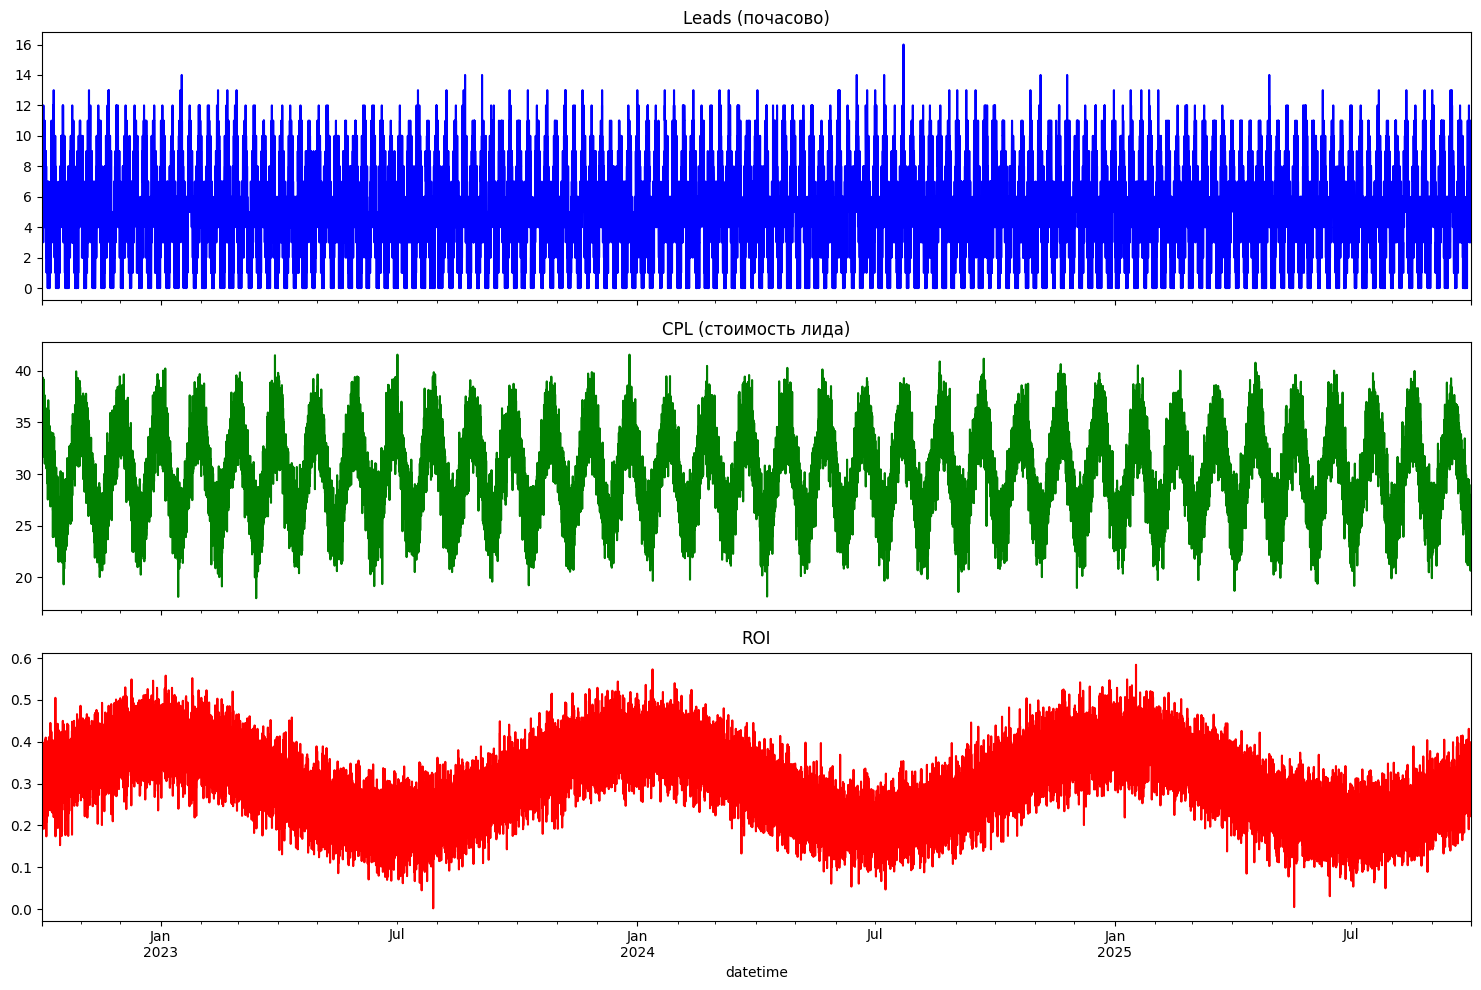

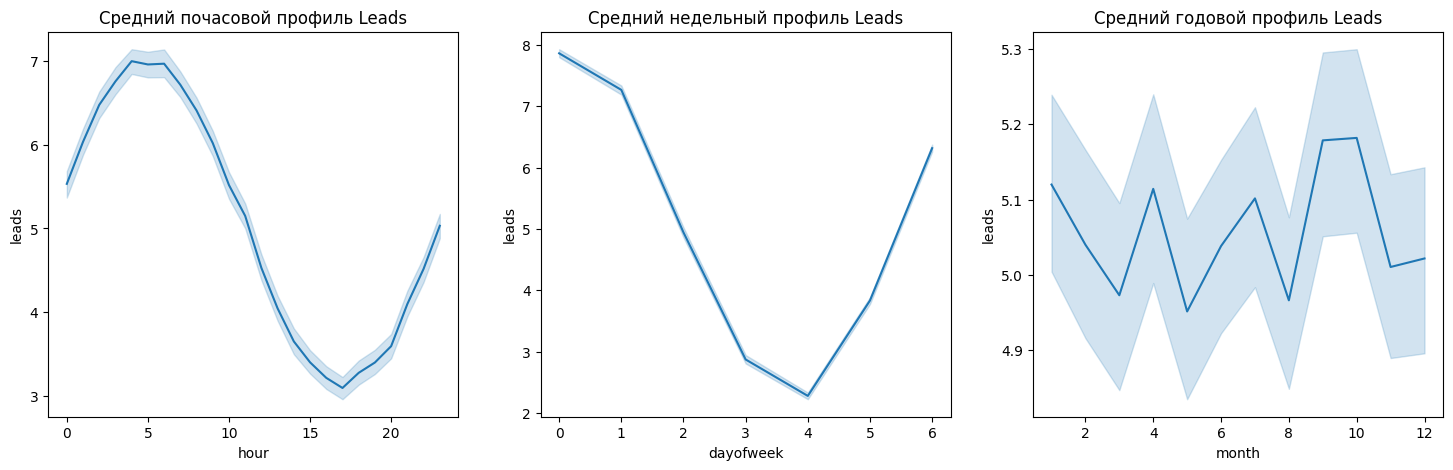

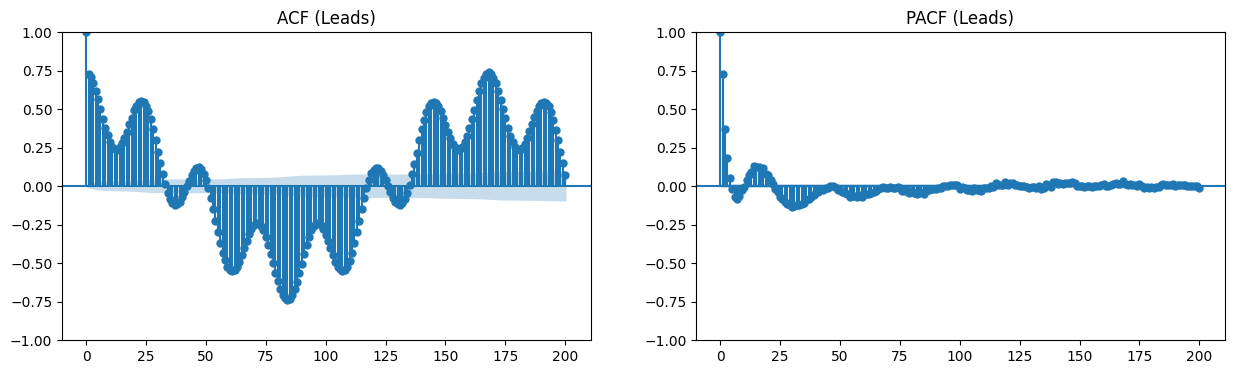

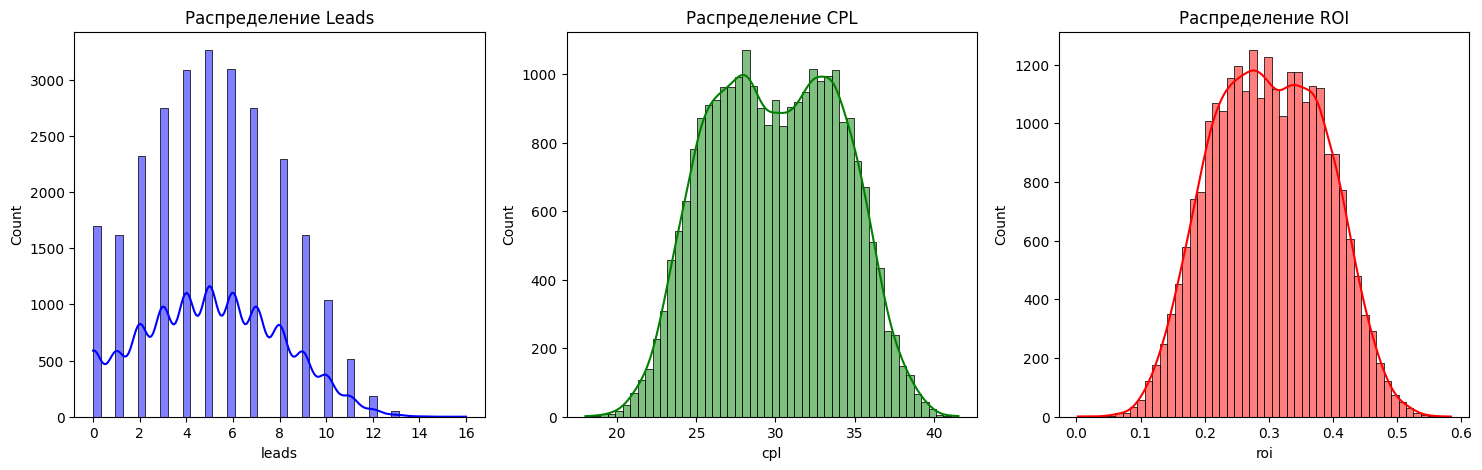

In [1]:
# EDA для respond_hourly.csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

DATA_PATH = Path("../data/respond_hourly.csv")

# --- 1. Загружаем данные ---
df = pd.read_csv(DATA_PATH, parse_dates=["datetime"])
df = df.set_index("datetime")

print("Размерность:", df.shape)
print(df.head())

# --- 2. Общая статистика ---
display(df.describe())

# --- 3. Временные ряды (основные графики) ---
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
df["leads"].plot(ax=axes[0], color="blue", title="Leads (почасово)")
df["cpl"].plot(ax=axes[1], color="green", title="CPL (стоимость лида)")
df["roi"].plot(ax=axes[2], color="red", title="ROI")
plt.tight_layout()
plt.show()

# --- 4. Средние профили ---
df["hour"] = df.index.hour
df["dayofweek"] = df.index.dayofweek
df["month"] = df.index.month

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.lineplot(data=df, x="hour", y="leads", ax=axes[0])
axes[0].set_title("Средний почасовой профиль Leads")

sns.lineplot(data=df, x="dayofweek", y="leads", ax=axes[1])
axes[1].set_title("Средний недельный профиль Leads")

sns.lineplot(data=df, x="month", y="leads", ax=axes[2])
axes[2].set_title("Средний годовой профиль Leads")
plt.show()

# --- 5. Автокорреляция ---
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
plot_acf(df["leads"], ax=axes[0], lags=200)
plot_pacf(df["leads"], ax=axes[1], lags=200)
axes[0].set_title("ACF (Leads)")
axes[1].set_title("PACF (Leads)")
plt.show()

# --- 6. Распределения ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(df["leads"], bins=50, ax=axes[0], color="blue", kde=True)
axes[0].set_title("Распределение Leads")

sns.histplot(df["cpl"], bins=50, ax=axes[1], color="green", kde=True)
axes[1].set_title("Распределение CPL")

sns.histplot(df["roi"], bins=50, ax=axes[2], color="red", kde=True)
axes[2].set_title("Распределение ROI")
plt.show()


# Exploratory Data Analysis (EDA) — RE:SPOND Dataset

В этом разделе мы исследуем синтетический датасет **respond_hourly.csv**, чтобы понять структуру данных и особенности временного ряда.  
Данные охватывают ~3 года, почасовая частота, три ключевые метрики: **leads**, **cpl**, **roi**.

---

## 1. Размерность и базовая статистика
- Размер: **26 281 строк × 3 колонки**  
- Основные показатели (см. таблицу ниже):
  - Средние значения: leads ≈ 5.06, cpl ≈ 30, roi ≈ 0.30
  - Диапазон: leads [0–16], cpl [18–42], roi [0–0.58]
- Это подтверждает, что данные сбалансированы: нет экстремальных выбросов.

---

## 2. Временные ряды
(см. график «Leads (почасово) / CPL / ROI»)

- **Leads (заявки)**: выраженные пики каждый день и каждую неделю, диапазон 0–16.  
- **CPL (стоимость лида)**: волнообразные колебания, заметен месячный и недельный цикл.  
- **ROI**: долгосрочные плавные колебания (годовая сезонность).

⚡ Уже здесь видно, что **Leads = основной кандидат для прогноза**.  
CPL и ROI больше для анализа стабильности и аномалий.

---

## 3. Сезонные профили
(см. три графика справа)

- **Почасовой профиль Leads**:
  - Пик утром (6–9 ч.)
  - Минимум вечером (15–20 ч.)
- **Недельный профиль Leads**:
  - Наибольшая активность в начале недели (пн–вт).
  - Минимум — четверг–пятница.
- **Годовой профиль Leads**:
  - Слабая выраженность, средние значения почти постоянны.

---

## 4. Автокорреляция (ACF/PACF)
(см. график ACF/PACF)

- **ACF**: чёткие пики на лагах 24 и 168 часов (сутки и неделя).  
- **PACF**: сильные корреляции на первых лагах (1–2 часа).  

✅ Это значит:
- нужно добавить **лаги (1–24 часа)**,  
- синус/косинус признаки для часа, дня недели и месяца.

---

## 5. Распределения
(см. гистограммы)

- **Leads**: дискретное распределение, максимум ≈ 5, «хвост» до 16.  
- **CPL**: почти нормальное, центр около 30, видна цикличность.  
- **ROI**: распределение около 0.3, «звонкое» и почти симметричное.

---

## 📌 Итог EDA
- Для прогнозирования:  
  - **Leads** = целевая переменная.  
  - Prophet и бустинги (LightGBM/XGBoost) будут лучшими кандидатами.  
  - Лаги и скользящие средние улучшат качество.  
- Для анализа:  
  - **CPL и ROI** — использовать в аномалиях.  
  - Z-score и IsolationForest хорошо подойдут.  

---

👉 Следующий шаг:  
- Используем `features.py` для генерации лагов и сезонных признаков.  
- Обучаем 10 моделей, логируем их в MLflow.  
- Выбираем лучшую по RMSE и R².
